# Modeling based on simple set of features

## The main point of this notebook is to set simple benchmarks using simple models and more complex models with a simple set of features

## We will try to predict the upside for each NFL prospect, so instead of running typical regression analysis (in which we would regress towards mean) we will develop quantile regression models to construct predictions for the 95th quantile (or percentile) for a player.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, RegressorMixin

from lightgbm import LGBMRegressor
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import shap

# Set up some global variables and plotting settings

In [2]:
sns.set(style="white", palette="colorblind", font_scale=1.35, 
        rc={"figure.figsize":(12,9)})

pd.options.display.max_columns = None
pd.options.display.max_rows = 50

# Global Variables 
RANDOM_STATE = 269
N_JOBS = 6

# Read in the data and set up features and target for modeling

In [3]:
train_df = pd.read_csv("processed_data/rb_train_data.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 40 columns):
Player                332 non-null object
Pos                   332 non-null object
College               332 non-null object
Ht                    332 non-null int64
Wt                    332 non-null int64
Forty                 332 non-null float64
Vertical              257 non-null float64
Bench                 243 non-null float64
Broad Jump            261 non-null float64
Cone                  196 non-null float64
Shuttle               192 non-null float64
Year                  332 non-null int64
Pfr_ID                255 non-null object
Sref_Cfb_ID           291 non-null object
Team_Drafted          193 non-null object
G                     291 non-null float64
Rush_Att              291 non-null float64
Rush_Yds              291 non-null float64
Rush_TD               291 non-null float64
Rec                   291 non-null float64
Rec_Yds               291 non-null float64
Rec_

In [5]:
train_df = train_df.replace([np.inf, -np.inf], np.nan)

## Select basic features for modeling
### I will just use basic Rushing Features and Combine information

In [6]:
# create yearly average rushing stats
rush_per_yr_cols = ["Rush_Att_per_Yr", "Rush_Yds_per_Yr", "Rush_TD_per_Yr"]
train_df[rush_per_yr_cols] = (train_df.loc[:, "Rush_Att":"Rush_TD"]
                                      .div(train_df.Col_Yrs_Played, axis=0)
                                      .fillna(0))

features = ["Rush_Att",
            "Rush_Yds",
            "Rush_TD",
            "Rush_Yds_per_Att",
            "Rush_Att_per_G",
            "Rush_Yds_per_G",
            "Rush_TD_per_G",
            "Rush_Att_per_Yr",
            "Rush_Yds_per_Yr",
            "Rush_TD_per_Yr",
            "Ht",
            "Wt",
            "Forty",
            "Vertical",
            "Bench",
            "Broad Jump",
            "Cone",
            "Shuttle"]

target = "AV"

X = train_df.loc[:, features]
y = train_df.loc[:, target]

## Construct CV folds based on years (i.e. Leave One Season Out Cross-Validation)

In [7]:
# # get a dictionary with the season as the key and the associated
# # row indices as the values
year_grpby = train_df.groupby("Year")
year_grpby.grouper.label_info
logo = LeaveOneGroupOut()
cv = list(logo.split(X, y, year_grpby.grouper.label_info))

# Basic Benchmarks
### Before setting up more complex models it"s good to have some basic benchmark models to compare to.

### Going forward we will evaluate models based on Quantile Loss (a.k.a. Pinball Loss)

In [8]:
def quantile_loss(y_true, y_pred, quantile=0.95):
    """
    Quantile Loss function to be used to score different qunatile regression 
    models. The code below is based on the logic from this blog post:
    https://www.lokad.com/pinball-loss-function-definition
    """
    loss = np.nanmean(
            # if real value (y_true) >= prediction (y_pred)
            # then calculate (real value - prediction) * quantile
            ((y_true >= y_pred) * (y_true - y_pred) * quantile) +
            # otherwise, if real value < prediction
            # then caclulate (prediction - real value) * (1 - quantile)
            (y_true < y_pred) * (y_pred - y_true) * (1 - quantile)
    )

    return loss

# create scorers
quant_95_scorer = make_scorer(quantile_loss, greater_is_better=False, 
                              quantile=.95)

## 95th quantile benchmark

In [9]:
dummy_95_model = DummyRegressor(strategy="quantile", quantile=.95)

dummy_95_scores = cross_val_score(dummy_95_model, X, y, 
                                    cv=cv, n_jobs=N_JOBS, 
                                    scoring=quant_95_scorer)

print("Mean quantile loss:", dummy_95_scores.mean())
print("Standard Deviation of quantile loss:", dummy_95_scores.std())
benchmark_std_er = dummy_95_scores.std() / (train_df.Year.nunique() ** 0.5)
print("Standard Error of quantile loss:", benchmark_std_er)

Mean quantile loss: -1.93975594136256
Standard Deviation of quantile loss: 0.34322546331936654
Standard Error of quantile loss: 0.09908065682008516


# Create Modeling Pipeline

## The modeling pipeline will consists of 3 parts, a scaler (for linear methods), an imputer (to fill in the missing data) and the estimator (i.e. learning algorithm).

In [10]:
pipe = Pipeline([("imputer", Imputer()),
                 ("scaler", StandardScaler()),
                 ("estimator", LGBMRegressor())])

# Create and Evaluate Models for 95th quantile

In [11]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ 
    A universal sklearn-style wrapper for statsmodels regressors based on code
    from here:
    https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible
    """
    def __init__(self, model_class, fit_intercept=True, fit_kwargs={}):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.fit_kwargs = fit_kwargs
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit(**self.fit_kwargs)
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [12]:
# search space for normal quantile rergression
imputation_strategies =  ["mean", "median", "most_frequent"]
qr_95_param_space = {
    "imputer__strategy": imputation_strategies,
    "estimator": [SMWrapper(QuantReg, fit_kwargs={"q":0.95})]
}

# search space for LGBM quantile regression
lgbm_95_param_space = {
    "imputer__strategy": Categorical(imputation_strategies),
    "scaler": Categorical([None]),
    "estimator": Categorical([LGBMRegressor(random_state=RANDOM_STATE,
                                            alpha=0.95,
                                            objective="quantile",
                                            n_estimtors=100)]),
    "estimator__max_depth": Integer(1, 25),
    "estimator__learning_rate" : Real(0.01, 0.3),
    "estimator__num_leaves": Integer(10, 500)
}

## Tune QR 95
#### Use gridsearch for normal quantile regression since we are only searching over imputation strategy

In [13]:
qr_95_grid_search = GridSearchCV(pipe, n_jobs=N_JOBS, param_grid=qr_95_param_space,
                                 cv=cv, scoring=quant_95_scorer, verbose=1,
                                 return_train_score=False)
qr_95_grid_search.fit(X, y)

Fitting 12 folds for each of 3 candidates, totalling 36 fits


/home/savvas/miniconda3/envs/nfl_quant/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/home/savvas/miniconda3/envs/nfl_quant/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/home/savvas/miniconda3/envs/nfl_quant/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/home/savvas/miniconda3/envs/nfl_quant/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed:    4.2s finished


GridSearchCV(cv=[(array([ 34,  35, ..., 330, 331]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])), (array([  0,   1, ..., 330, 331]), array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50... 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331]))],
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, m....0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'imputer__strategy': ['mean', 'median', '

In [14]:
qr_95_grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', SMWrapper(fit_intercept=True, fit_kwargs={'q': 0.95},
     model_class=<class 'statsmodels.regression.quantile_regression.QuantReg'>))])

In [15]:
qr_95_cv_results = pd.DataFrame(qr_95_grid_search.cv_results_)

In [16]:
qr_95_cv_results["std_er_test_score"] = (qr_95_cv_results.std_test_score / 
                                         (train_df.Year.nunique() ** 0.5))

In [17]:
(qr_95_cv_results[["mean_test_score", "std_test_score", "std_er_test_score",
                   "param_imputer__strategy"]]
     .sort_values("mean_test_score", ascending=False))

,mean_test_score,std_test_score,std_er_test_score,param_imputer__strategy
0,-1.799779,0.375831,0.108493,mean
1,-1.938527,0.471409,0.136084,median
2,-2.017953,0.647184,0.186826,most_frequent


## Tune LGBM 95

### Here we will use Bayesian Optimization to tune the model

In [18]:
lgbm_95_search = BayesSearchCV(pipe, 
                               lgbm_95_param_space, 
                               cv=cv,
                               n_jobs=N_JOBS, 
                               verbose=1, 
                               error_score=-9999, 
                               scoring=quant_95_scorer, 
                               random_state=RANDOM_STATE,
                               return_train_score=False, 
                               n_iter=18)

In [19]:
lgbm_95_search.fit(X, y)

Fitting 12 folds for each of 1 candidates, totalling 12 fits
Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   52.2s finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   48.1s finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   51.9s finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   48.6s finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   58.7s finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.2min finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.1min finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.1min finished
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.3min finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.1min finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.1min finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   19.7s finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   49.9s finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.4min finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   19.3s finished


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  1.2min finished
/home/savvas/miniconda3/envs/nfl_quant/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   20.3s finished
/home/savvas/miniconda3/envs/nfl_quant/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 12 folds for each of 1 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:   19.5s finished


BayesSearchCV(cv=[(array([ 34,  35, ..., 330, 331]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])), (array([  0,   1, ..., 330, 331]), array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50... 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331]))],
       error_score=-9999,
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, m....0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_iter=18, n_jobs=6, n_points=1,
       optimizer_kwargs=None, pre_disp

In [20]:
lgbm_95_search.best_estimator_

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', None), ('estimator', LGBMRegressor(alpha=0.95, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, learning_rate=0.3, max_depth=1,
       min_child_samples=20, min_child_wei...    reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [21]:
lgbm_95_search.best_params_

{'estimator': LGBMRegressor(alpha=0.95, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, learning_rate=0.3, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_estimtors=100, n_jobs=-1, num_leaves=10,
        objective='quantile', random_state=269, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
 'estimator__learning_rate': 0.3,
 'estimator__max_depth': 1,
 'estimator__num_leaves': 10,
 'imputer__strategy': 'mean',
 'scaler': None}

In [22]:
lgbm_95_cv_results = pd.DataFrame(lgbm_95_search.cv_results_)

In [23]:
lgbm_95_cv_results["std_er_test_score"] = (lgbm_95_cv_results.std_test_score / 
                                         (train_df.Year.nunique() ** 0.5))

In [24]:
lgbm_cv_cols = ["mean_test_score", "std_test_score", "std_er_test_score",
                "param_imputer__strategy", "param_estimator__max_depth",
                "param_estimator__learning_rate", "param_estimator__num_leaves"]
                
(lgbm_95_cv_results[lgbm_cv_cols].sort_values("mean_test_score", ascending=False))

,mean_test_score,std_test_score,std_er_test_score,param_imputer__strategy,param_estimator__max_depth,param_estimator__learning_rate,param_estimator__num_leaves
17,-1.632307,0.524328,0.151360,mean,1,0.300000,10
16,-1.632307,0.524328,0.151360,mean,1,0.300000,10
14,-1.632307,0.524328,0.151360,mean,1,0.300000,10
12,-1.788871,0.306923,0.088601,mean,3,0.010000,10
9,-1.803354,0.406064,0.117221,mean,12,0.018729,86
11,-1.807381,0.275004,0.079387,mean,1,0.010000,10
10,-1.809690,0.323390,0.093355,mean,6,0.010000,10
6,-1.869019,0.540305,0.155973,mean,12,0.031573,215
8,-1.933462,0.632474,0.182580,mean,24,0.051682,192
7,-1.944651,0.681574,0.196753,mean,4,0.208841,113


### Convergence Plot

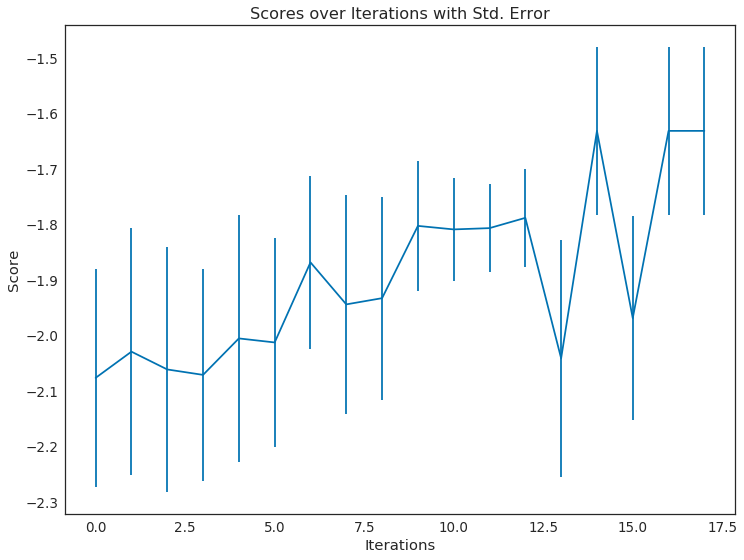

In [25]:
lgbm_95_cv_results.sort_index().plot(y='mean_test_score', 
                                     yerr='std_er_test_score',
                                     title="Scores over Iterations with Std. Error",
                                     legend=False)
plt.xlabel("Iterations")
plt.ylabel("Score");

# Model Comparison
## Compare the Cross-Validation (CV) performance for the best model of each algorithm

In [26]:
cols = ["mean_test_score", "std_er_test_score"]

models = ["Benchmark", "Linear QR", "LGBM QR"]

model_data = [[dummy_95_scores.mean(), benchmark_std_er],
              qr_95_cv_results.loc[qr_95_grid_search.best_index_, cols].tolist(),
              lgbm_95_cv_results.loc[lgbm_95_search.best_index_, cols].tolist()]
best_models_df = pd.DataFrame(model_data, columns=cols).reset_index(drop=True)
best_models_df["model"] = models
best_models_df.sort_values('mean_test_score', inplace=True, ascending=False)
best_models_df.reset_index(inplace=True, drop=True)
best_models_df

,mean_test_score,std_er_test_score,model
0,-1.632307,0.151360,LGBM QR
1,-1.799779,0.108493,Linear QR
2,-1.939756,0.099081,Benchmark


In [27]:
best_models_df.loc[0, cols].diff() * -1

mean_test_score          NaN
std_er_test_score   -1.78367
Name: 0, dtype: object

/home/savvas/miniconda3/envs/nfl_quant/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fd4047e4a20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


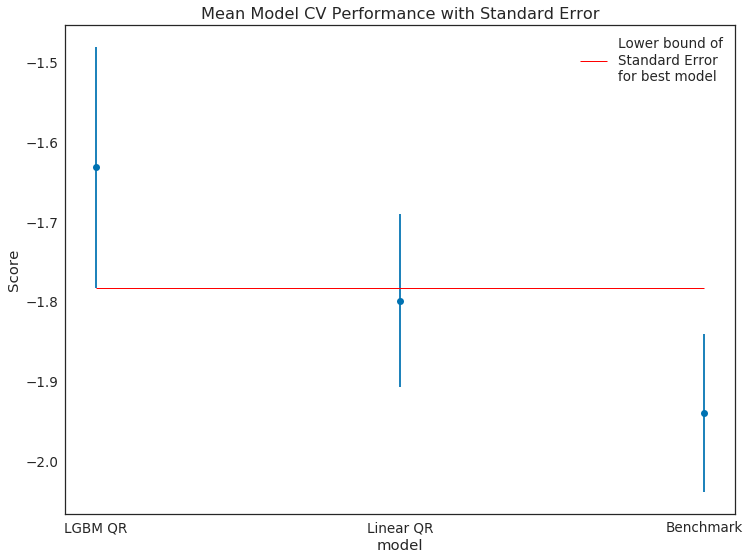

In [28]:
best_models_df.plot(x='model', y='mean_test_score', yerr='std_er_test_score',
                    fmt='o', label='_nolegend_',
                    title='Mean Model CV Performance with Standard Error')
# bug with pandas doesn't show x-ticks, need to do it manually
# https://stackoverflow.com/questions/32572419/matplotlib-not-showing-all-x-axis-data-frame-variable
plt.xticks(range(len(best_models_df.model)), best_models_df.model)
best_model_bound = best_models_df.loc[0, cols].diff() * -1
plt.hlines(best_model_bound, xmin=0, 
           xmax=(len(best_models_df.model))-1,
           linestyle='-', linewidth=1, colors='r', 
           label='Lower bound of\nStandard Error\nfor best model')
plt.legend()
plt.ylabel('Score');

# Interpret the model

In [29]:
estimator = lgbm_95_search.best_estimator_.named_steps["estimator"]
# impute the data to pass to shap explainer
X_imp = lgbm_95_search.best_estimator_.named_steps["imputer"].transform(X)
X_imp_df = pd.DataFrame(X_imp, columns=features)

In [30]:
shap_explainer = shap.TreeExplainer(estimator)
shap_values = shap_explainer.shap_values(X_imp)

In [31]:
# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()

In [32]:
shap.force_plot(shap_values[0, :], X_imp_df.iloc[0, :])

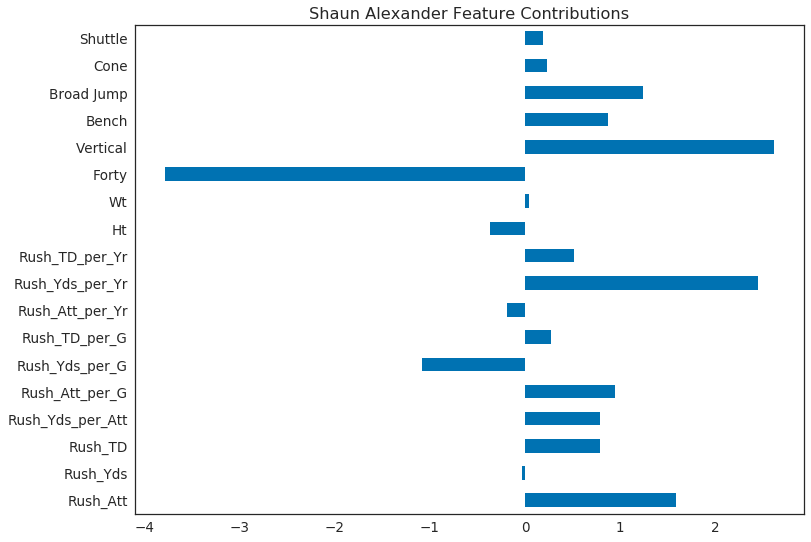

In [33]:
shap_values_df = pd.DataFrame(shap_values, columns=features+["mean"])
col_ids = ['Player', 'Pfr_ID', 'Sref_Cfb_ID']
shap_values_df[col_ids] = train_df[col_ids]

(shap_values_df.loc[shap_values_df.Player=="Shaun Alexander", features]
               .T
               .plot
               .barh(legend=False, title="Shaun Alexander Feature Contributions"));

In [34]:
shap.force_plot(shap_values, X_imp_df)

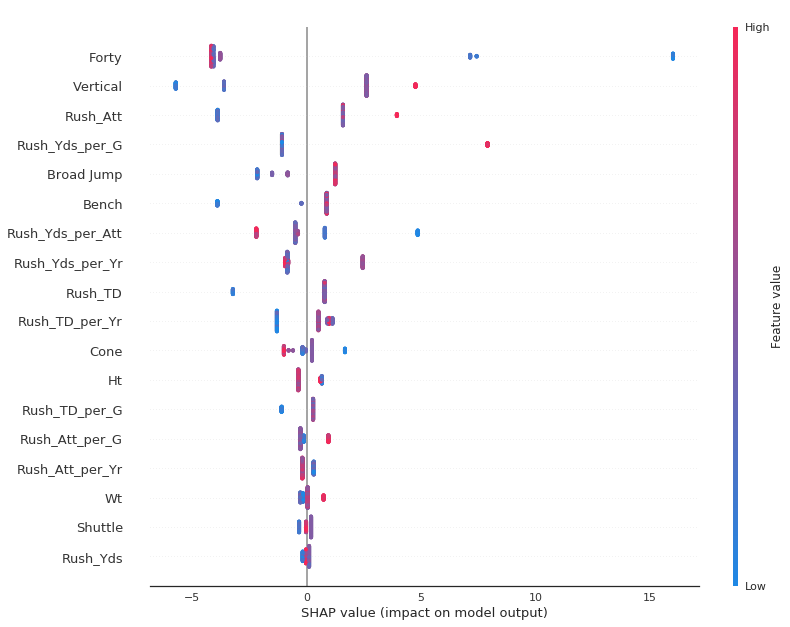

In [35]:
shap.summary_plot(shap_values, X_imp_df, auto_size_plot=False)

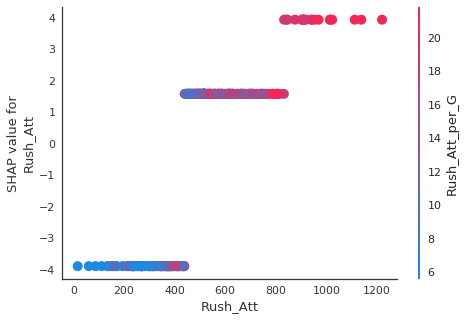

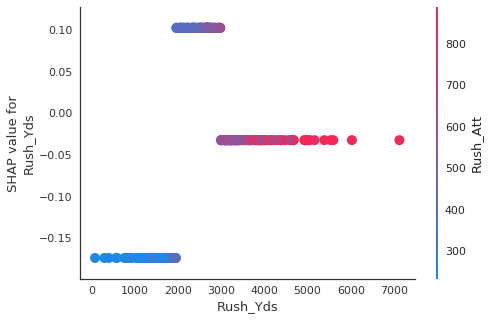

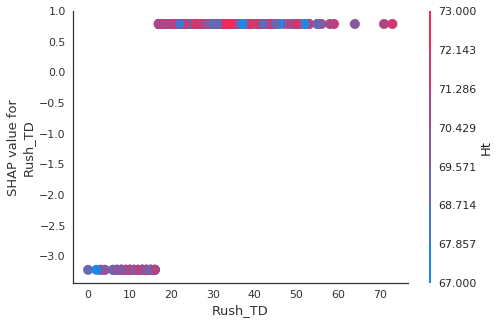

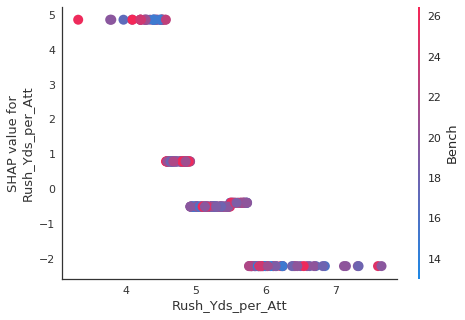

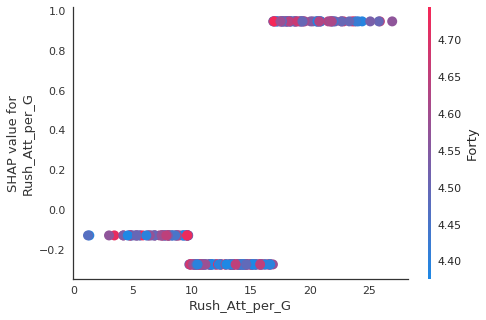

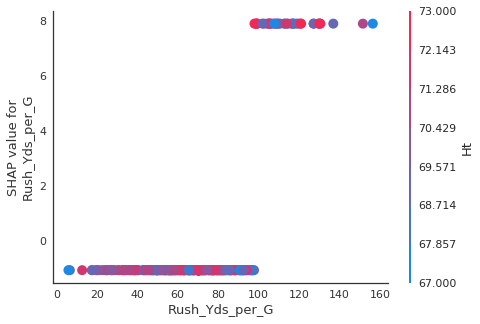

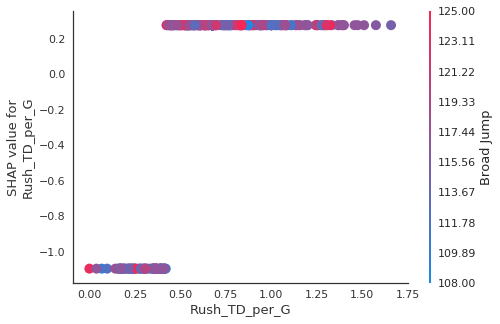

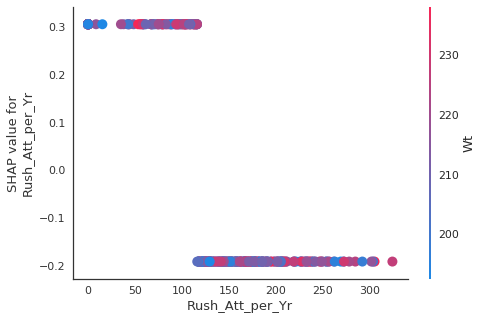

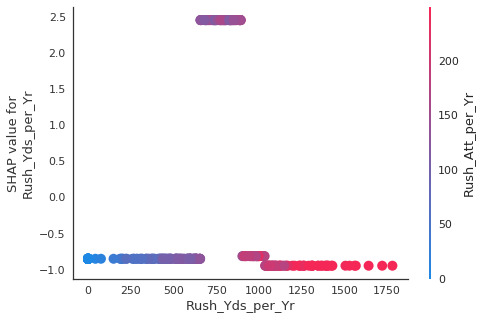

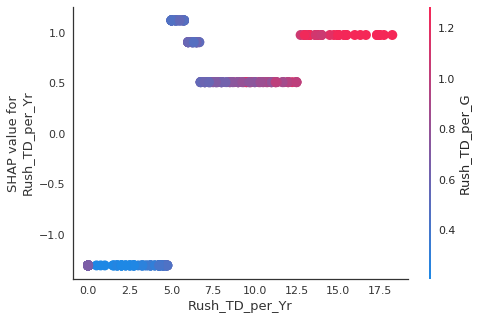

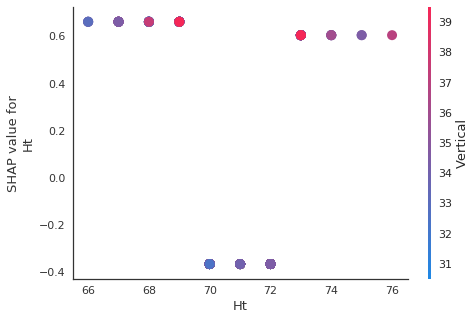

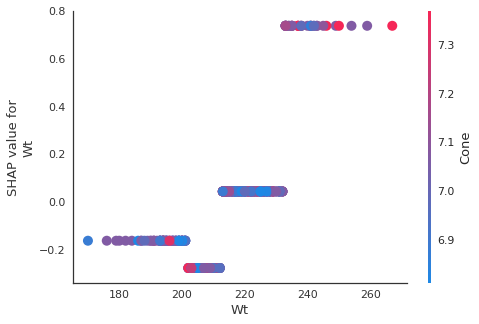

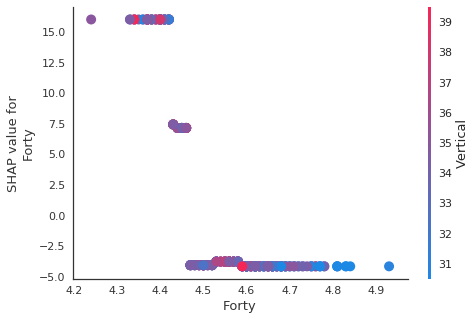

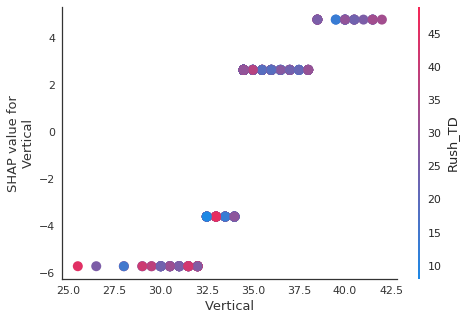

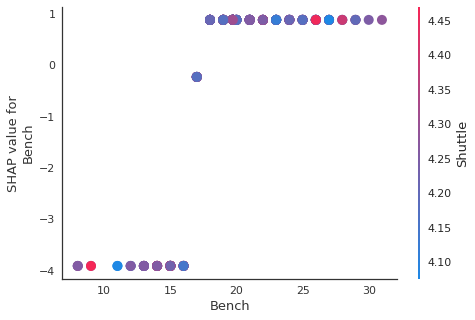

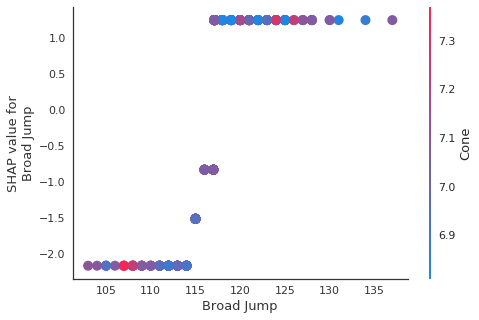

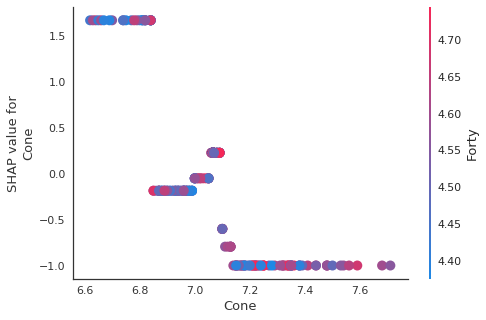

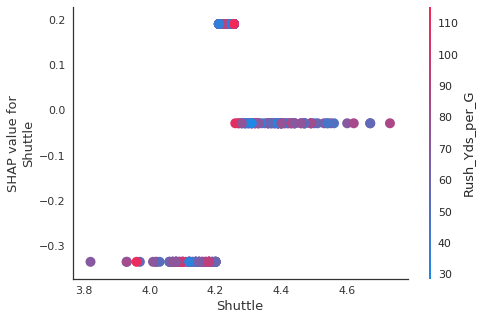

In [36]:
for feat in features:
    shap.dependence_plot(feat, shap_values, X_imp_df, dot_size=100)

# Export best model

In [37]:
joblib.dump(lgbm_95_search.best_estimator_, "models/best_model_04.01.pkl")

['models/best_model_04.01.pkl']